In [1]:
import torch
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import copy
import os
from baselines.ViT.ViT_explanation_generator import LRP

import torch
import Simple_ViT.simple_vit_lrp as svitl

In [2]:
class LRP2:
    def __init__(self, model):
        self.model = model
        self.model.eval()

    def generate_LRP(self, input, index=None, method="transformer_attribution", is_ablation=False, start_layer=0):
        output = self.model(input)
        print(output)
        print(output.shape)
        kwargs = {"alpha": 1}
        if index == None:
            index = np.argmax(output.cpu().data.numpy(), axis=-1)

        one_hot = np.zeros((1, output.size()[-1]), dtype=np.float32)
        one_hot[0, index] = 1
        print(one_hot)
        one_hot_vector = one_hot
        one_hot = torch.from_numpy(one_hot).requires_grad_(True)
        one_hot = torch.sum(one_hot.cuda() * output)

        self.model.zero_grad()
        one_hot.backward(retain_graph=True)

        return self.model.relprop(torch.tensor(one_hot_vector).to(input.device), method=method, is_ablation=is_ablation,
                                  start_layer=start_layer, **kwargs)


In [3]:
def set_gpu(gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
gpu_id=0

if gpu_id >= 0:
    device = "cuda"
    set_gpu(gpu_id)
    print('device available :', torch.cuda.is_available())
    print('device count: ', torch.cuda.device_count())
    print('current device: ',torch.cuda.current_device())
    print('device name: ',torch.cuda.get_device_name())
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
else:
    device = torch.device('cpu')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

print('using device: ', device)

device available : True
device count:  1
current device:  0
device name:  NVIDIA A100-SXM4-80GB
NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB
using device:  cuda


In [6]:
PATH = 'saved_models/benchmark/model003.pt'
model = torch.load(PATH).to(device)
# model.eval()

In [8]:
model_test = svitl.VisionTransformer(
        image_lr = 36,
        image_ud = 18,
        patch_size = 1,
        num_classes = 1,
        in_chans = 1,
        embed_dim = 768,
        depth = 8,
        num_heads = 32,
        mlp_ratio = 2.,
    ).to(device)

In [9]:
x_test = torch.rand((36,18))

In [7]:
dir_fil = '/glade/work/wchapman/ViT_XAI/Data_Staging/Mamalakis_Dataset/scp_synth_exm_data.nc'
Data_ = xr.open_dataset(dir_fil)
Data_train = np.expand_dims(Data_['SSTrand'].isel(time=slice(0,900000)),1)
Y_train = np.array(Data_['y'].isel(time=slice(0,900000)))

Data_val = np.expand_dims(Data_['SSTrand'].isel(time=slice(950000,1000000)),1)
Y_val = np.array(Data_['y'].isel(time=slice(950000,1000000)))

Data_test = np.expand_dims(Data_['SSTrand'].isel(time=slice(900000,950000)),1)
Y_test = np.array(Data_['y'].isel(time=slice(900000,950000)))

In [16]:
x = torch.nan_to_num(torch.tensor(Data_val[29475], dtype=torch.float32))
# model(x.unsqueeze(0).to(device))

In [38]:
attribution_generator = LRP(model)
transformer_attribution = attribution_generator.generate_LRP(x.unsqueeze(0).to(device), method="transformer_attribution", index=0).detach()

In [39]:
transformer_attribution = transformer_attribution.reshape(1, 1, 18, 9)
transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=2, mode='bilinear')
transformer_attribution = transformer_attribution.reshape(36, 18).data.cpu().numpy()

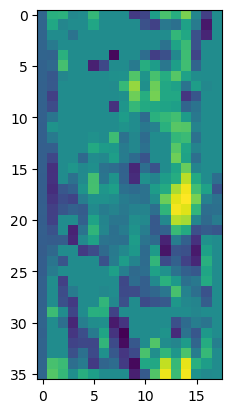

In [25]:
plt.imshow(x.squeeze().cpu())

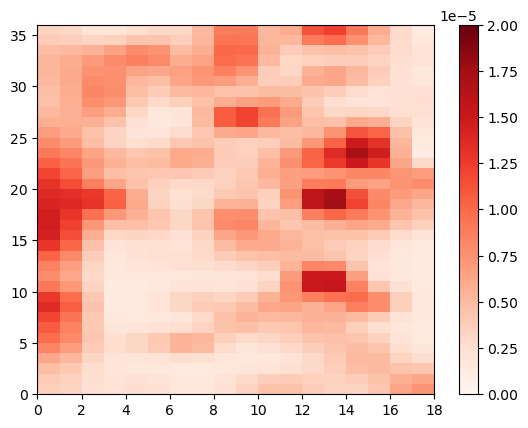

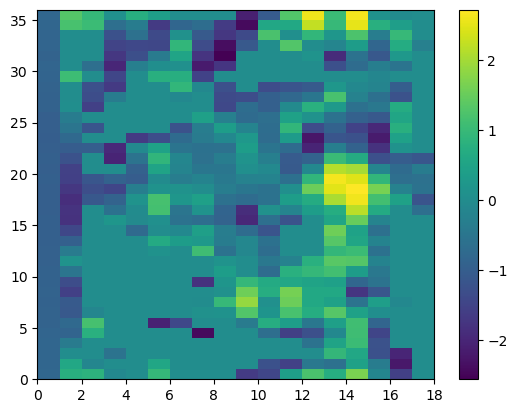

In [40]:
plt.pcolormesh(transformer_attribution.squeeze(),cmap='Reds', vmin=0, vmax=2*1e-5)
plt.colorbar()
plt.show()

plt.pcolormesh(x.squeeze().cpu())
plt.colorbar()
plt.show()

In [ ]:
def generate_visualization(original_image, class_index=None):
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index).detach()
    transformer_attribution = transformer_attribution.reshape(1, 1, 36, 18)
    # transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    # transformer_attribution = transformer_attribution.reshape(224, 224).data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())

    if use_thresholding:
      transformer_attribution = transformer_attribution * 255
      transformer_attribution = transformer_attribution.astype(np.uint8)
      ret, transformer_attribution = cv2.threshold(transformer_attribution, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
      transformer_attribution[transformer_attribution == 255] = 1

    image_transformer_attribution = original_image.permute(1, 2, 0).data.cpu().numpy()
    image_transformer_attribution = (image_transformer_attribution - image_transformer_attribution.min()) / (image_transformer_attribution.max() - image_transformer_attribution.min())
    vis = show_cam_on_image(image_transformer_attribution, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    return vis

def print_top_classes(predictions, **kwargs):    
    # Print Top-5 predictions
    prob = torch.softmax(predictions, dim=1)
    class_indices = predictions.data.topk(5, dim=1)[1][0].tolist()
    max_str_len = 0
    class_names = []
    for cls_idx in class_indices:
        class_names.append(CLS2IDX[cls_idx])
        if len(CLS2IDX[cls_idx]) > max_str_len:
            max_str_len = len(CLS2IDX[cls_idx])
    
    print('Top 5 classes:')
    for cls_idx in class_indices:
        output_string = '\t{} : {}'.format(cls_idx, CLS2IDX[cls_idx])
        output_string += ' ' * (max_str_len - len(CLS2IDX[cls_idx])) + '\t\t'
        output_string += 'value = {:.3f}\t prob = {:.1f}%'.format(predictions[0, cls_idx], 100 * prob[0, cls_idx])
        print(output_string)

In [ ]:
generate_visualization(x)